In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch
from tqdm import tqdm 
from torch import nn
from torch.optim import Adam
from scipy.special import gammaln

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import LowRankMultivariateNormal
from numpy.lib.stride_tricks import sliding_window_view
from models.last_layer_models import LLI, train_last_layer_det, LastLayerVIClosedForm
from utils.data_utils import create_synthetic_train_data
from models.vi import run_last_layer_vi_closed_form


np.random.seed(100)

# VI with a Gausian var. distribution \& closed form ELBO

We want to approximate the posterior of the following model
\begin{align}
y = w^T \psi(x) + \varepsilon, \qquad \varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \qquad w \sim \mathcal{N}(0, \tau^2I)
\end{align}
where we assume $\sigma_{\varepsilon}$ and $\tau^2$ to be fixed and known. We have a standard normal prior on the last-layer weights.
In this case we can write the ELBO in closed-form as 

\begin{align*}
        \text{ELBO}(\lambda) = \textcolor{purple}{E_{q_(\lambda)}[\log p(y \mid x, w)]} - \textcolor{green}{KL( q_{\lambda}(w) || p(w))} = \textcolor{purple}{\log \phi_1(y ; \mu_{w}^T \psi , \sigma_{\varepsilon}^2) - \frac{1}{2}\sigma_{\varepsilon}^{-2} \psi^T \Sigma_w \psi}  - \textcolor{green}{KL( q_{\lambda}(w) || p(w))},
\end{align*}

where $\textcolor{purple}{q_{\lambda}(w) = \phi_1(w; \mu_w, \Sigma_w)}$. We have a variational distribution with a full covariance matrix.\
For new observations we can obtain the predictive posterior distribution conditional on the parameters $\mu_w, \tau^2$
\begin{align}
p(y | x, \mu_w, \tau^2) = \mathcal{N}(\mu_w^T\psi, \psi^T \Sigma_w \psi + \sigma_{\varepsilon}^2I).
\end{align}

## 1. Data
First, we set up a synthetic dataset using a noisy sine function, where $y = \sin(x) + \varepsilon$ where $\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2)$.

In [2]:
sigma_eps = 0.3
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = sigma_eps)
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

## 2. Model
We use a dense, feedforward neural network with ReLU activations in all but the output layer.

In [3]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100

# initialize model
lli_net = LLI(model_dims)
    
# train model
model, losses_train, losses_val = train_last_layer_det(model = lli_net, dataloader_train = dataloader_train,
                     dataloader_val= dataloader_train, weight_decay = 0, num_epochs = 100)

# freeze weights after training
for param in lli_net.parameters():
    param.requires_grad = False

# get last-layer embeddings psi
with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

100%|██████████| 100/100 [00:00<00:00, 125.75it/s]


## 3. Run VI with closed-form ELBO
We now run VI with the closed-form ELBO objective from above. Because the objective is available in closed-form, we don't have to draw samples from $q_{\lambda}$.
In each VI iteration, we
1. Compute $\hat{y}$ based on the current variational parameters
2. Compute the exp. log-likelihood $\textcolor{purple}{E_{q_(\lambda)}[\log p(y \mid x, w)]}$ and KL term $\textcolor{green}{KL( q_{\lambda}(w) || p(w))}$ for the ELBO.
3. Update the variational parameters to maximize the ELBO $\lambda^{[t + 1]} = \lambda^{[t]} - \nabla_{\lambda}\text{ELBO}(\lambda)$.

We set the prior variance for $w$ as $\tau^2 = 1$ and the variance for the observational noise to the true value $\sigma_{\varepsilon} = 0.3$.

In [4]:

last_layer_vi = LastLayerVIClosedForm(dim_last_layer=Psi.shape[1], dim_output=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-2)
num_epochs = 10000
sigma_eps_sq = sigma_eps**2

In [5]:
last_layer_vi, elbos = run_last_layer_vi_closed_form(model = last_layer_vi, 
                              ys_train = ys_train, 
                              Psi = Psi, sigma_eps_sq = sigma_eps_sq, 
                              lr = 1e-2, temperature = 1, num_epochs = 1000)

VI epoch 0 ELBO: -2027.096 
 'log likelihood: -2026.427
VI epoch 100 ELBO: -316.179 
 'log likelihood: -313.992
VI epoch 200 ELBO: -157.613 
 'log likelihood: -154.196
VI epoch 300 ELBO: -100.454 
 'log likelihood: -96.233
VI epoch 400 ELBO: -73.336 
 'log likelihood: -68.466
VI epoch 500 ELBO: -58.358 
 'log likelihood: -52.945
VI epoch 600 ELBO: -49.230 
 'log likelihood: -43.350
VI epoch 700 ELBO: -43.259 
 'log likelihood: -36.972
VI epoch 800 ELBO: -39.142 
 'log likelihood: -32.499
VI epoch 900 ELBO: -36.189 
 'log likelihood: -29.230


Text(0, 0.5, 'ELBO')

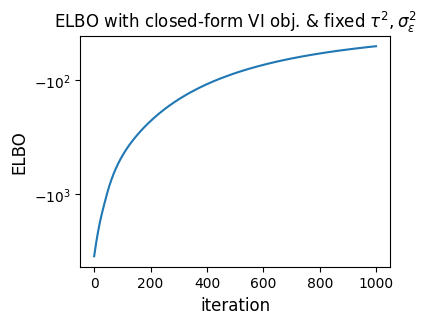

In [17]:
fig, axs = plt.subplots(1,1, figsize = (4,3))
axs.plot(elbos)
axs.set_yscale('symlog')
axs.set_title(r'ELBO with closed-form VI obj. & fixed $\tau^2, \sigma_{\varepsilon}^2$')
axs.set_xlabel('iteration', size = 12)
axs.set_ylabel('ELBO', size = 12)

## 4. Predictions
Compute the predictive mean and standard deviation using
\begin{align}
p(y | x, \mu_w, \tau^2) = \mathcal{N}(\mu_w^T\psi, \psi^T \Sigma_w \psi + \sigma_{\varepsilon}^2I).
\end{align}

In [18]:
X_test = torch.linspace(-10,10, 300).unsqueeze(1)
Psi_test = lli_net.get_ll_embedd(X_test)
pred_mean = (Psi_test @  last_layer_vi.mu.T).detach().numpy().squeeze()
L  = last_layer_vi.get_L()
Z = Psi_test @ L.squeeze()  
pred_std = torch.sqrt((Z ** 2).sum(dim=1) + sigma_eps_sq).detach().numpy()

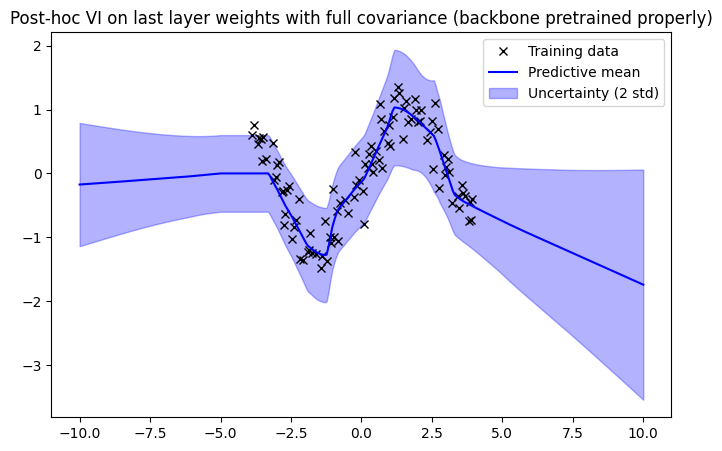

In [19]:
plt.figure(figsize=(8,5))
#plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance (backbone pretrained properly)")
plt.show()

# Ridge

We now want to perform the same estimation, but with a more sophisticated model: a hierarchical model with a ridge prior.
We now equip both $\tau^2$ and $\sigma_{\varepsilon}^2$ with inverse-gamma priors. 
Before, we merely guessed their values - or "cheated" a bit because we used the true value of $\sigma_{\varepsilon}^2$.
Equipping both variances with priors protects us from severe misspecification of these values.

We now have
\begin{align}
\tau^2 \sim  \mathcal{IG}(a_\tau, b_{\tau}) \qquad \sigma_{\varepsilon}^2 \sim \mathcal{IG}(a_\sigma, b_{\sigma}),
\end{align}
where $a_\tau > 0 $ ($a_\sigma$) is the shape and $b_{\tau} > 0$ ($b_{\sigma}$) is the scale. To get an "uninformative" prior, we can set $a = 2, b=2$.
It's obvious, that our misspeficiation now merely moved one layre up in the hierarchy. We could of course still very much choose "bad" values of $a,b$. But these will have a smaller influence then directly misspecifying $\tau^2, \sigma_{\varepsilon}^2$.

Our variational distribution now has two additional parameters: $\log(\tau^2), \log(\sigma_{\varepsilon}^2)$. We need to reparameterize them with logarithms because the normal distribution can take on pos. and neg. values - but the variances are only positive.

Our ELBO now looks a bit different then before. We still have the expected log-likelihood but several KL terms for our different priors:
\begin{align}
\text{ELBO}(\lambda) = \textcolor{purple}{E_{q_\lambda}[\log p(y \mid x, w, \tau^2, \sigma_{\varepsilon}^2)]} - \textcolor{green}{\mathbb{E}_{q_\lambda}[KL(q_{\lambda}(w) || p(w | \tau^2))]} - \textcolor{red}{KL( q_{\lambda}(\tau^2) || p(\tau^2))} - \textcolor{blue}{KL( q_{\lambda}(\sigma_{\varepsilon}^2) || p(\sigma_{\varepsilon}^2))}
\end{align}
We now only use a diagonal covariance matrix in the variational density $q$.

Let's again set up our LastLayerVI class.

In [8]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)


class LastLayerVI(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_tau_sq = nn.Parameter(torch.ones(out_features, 1))
        self.log_sigma_eps_sq = nn.Parameter(torch.ones(out_features, 1))

        self.Sigma_q_unconstrained = nn.Parameter(torch.randn(out_features, in_features + 2) * 0.01)
    
    def get_tau_sq(self):
        return torch.nn.functional.exp(self.log_tau_sq)
    
    def get_sigma_eps_sq(self):
        return torch.nn.functional.exp(self.log_sigma_eps_sq)

    def get_Sigma_q(self):
        Sigma_q = torch.nn.functional.softplus(self.Sigma_q_unconstrained) + 1e-5
        return Sigma_q
    
    def forward(self, X, S = 5):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        Sigma_q = self.get_Sigma_q()
        params_samples = params + L*eps

        y_sample = X @ params_samples[:, :self.in_features].t()
        
        return params_samples, params, y_sample, Sigma_q
    
    def forward_sample(self, X, S = 1):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        L = self.get_Sigma_q()
        params_samples = params + L*eps
        w_sample = params_samples[:, :self.in_features]

        y_sample = X @ w_sample.T # variance is missing here
        
        return y_sample

In [9]:
last_layer_vi = LastLayerVI(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-3)
num_epochs = 30000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [4]:
def kl_w_vectorized(mu, Sigma_q, tau_sq_samples):
    _, L = mu.shape

    logdet_Sigma = torch.sum(torch.log(Sigma_q), dim=1)
    trace_term = torch.sum(Sigma_q, dim=1)              
    mu_norm_sq = torch.sum(mu**2, dim=1)                
    log_tau_sq = torch.log(tau_sq_samples)               

    kl = 0.5 * (trace_term / tau_sq_samples + mu_norm_sq / tau_sq_samples - L + L * log_tau_sq - logdet_Sigma)

    return kl.mean()

def kl_tau_sq(q_log_pdf_normal_value, tau_sq_samples, a_tau, b_tau):
    log_prior_ig = (
        a_tau * torch.log(torch.tensor(b_tau)) 
        - torch.lgamma(torch.tensor(a_tau))
        - (a_tau + 1) * torch.log(tau_sq_samples) 
        - b_tau / tau_sq_samples
    )
    
    kl = q_log_pdf_normal_value.mean() - log_prior_ig.mean()
    return kl

def q_log_pdf_lognormal(sigma_eps_sq_samples, mu_log, log_var_log):

    var_log = torch.exp(log_var_log)
    log_x = torch.log(sigma_eps_sq_samples)
    log_pdf = (
        - log_x
        - 0.5 * torch.log(2 * torch.pi * var_log)
        - (log_x - mu_log)**2 / (2 * var_log)
    )
    return log_pdf

def log_p_sigma_eps_sq_ig(sigma_eps_sq, a_sigma, b_sigma):
    log_prob1 = a_sigma * math.log(b_sigma) - gammaln(a_sigma)
    log_prob2 = -(a_sigma + 1) * torch.log(sigma_eps_sq) - b_sigma / sigma_eps_sq
    return log_prob1 + log_prob2  # shape [S]

def kl_sigma_eps_sq(q_log_pdf, sigma_eps_sq_samples, a_sigma, b_sigma):
    log_prior = log_p_sigma_eps_sq_ig(sigma_eps_sq_samples, a_sigma, b_sigma)
    return (q_log_pdf - log_prior).mean()

In [13]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    params_samples, params, y_sample, Sigma_q = last_layer_vi.forward(Psi)

    # samples of parameters
    w_samples =  params_samples[:, :last_layer_vi.in_features]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5
    tau_sq_samples = torch.exp(params_samples[:, -2]) + 1e-5

    # variational means
    q_w_mu = params[:, :last_layer_vi.in_features]
    q_log_tau_sq_mu = params_samples[:, -2]
    q_log_sigma_eps_sq_mu = params_samples[:, -1]

    q_log_sigma_eps_sq_var = Sigma_q[:, -1]
    q_log_tau_sq_var = Sigma_q[:, -2]

    # likelihood
    log_likelihood = (
        - 0.5 * N * torch.log(sigma_eps_sq_samples) 
        - 0.5 * (torch.sum((ys_train - y_sample) ** 2)/ sigma_eps_sq_samples))
    
    # expected KL
    kl_w = kl_w_vectorized(w_samples, Sigma_q[:,:last_layer_vi.in_features], tau_sq_samples)
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)
    q_log_pdf_normal_value_tau_value = q_log_pdf_lognormal(tau_sq_samples, q_log_tau_sq_mu, q_log_tau_sq_var)
    kl_tau_sq_value = kl_tau_sq(q_log_pdf_normal_value_tau_value, tau_sq_samples, 2, 2)
    
    elbo = (
        log_likelihood.mean() 
        - kl_w - kl_sigma_eps_sq_value - kl_tau_sq_value
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 1000 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())

VI epoch 0 ELBO: -2172689920.000
VI epoch 1000 ELBO: -1390001280.000
VI epoch 2000 ELBO: -133631536.000
VI epoch 3000 ELBO: -1245095680.000
VI epoch 4000 ELBO: -2391.257
VI epoch 5000 ELBO: -3779545856.000
VI epoch 6000 ELBO: -277520.625
VI epoch 7000 ELBO: -33399.059
VI epoch 8000 ELBO: -1475691.750
VI epoch 9000 ELBO: -31984.156
VI epoch 10000 ELBO: -1084458.000
VI epoch 11000 ELBO: -5559232.500
VI epoch 12000 ELBO: -570880192.000
VI epoch 13000 ELBO: -7941422080.000
VI epoch 14000 ELBO: -10366060544.000
VI epoch 15000 ELBO: -675289856.000
VI epoch 16000 ELBO: -4058359.000
VI epoch 17000 ELBO: -44522.262
VI epoch 18000 ELBO: -10357640.000
VI epoch 19000 ELBO: -898132416.000
VI epoch 20000 ELBO: -919356.438
VI epoch 21000 ELBO: -38751.020
VI epoch 22000 ELBO: -118361.031
VI epoch 23000 ELBO: -11951154.000
VI epoch 24000 ELBO: -5782057.000
VI epoch 25000 ELBO: -5922085.000
VI epoch 26000 ELBO: -57779.488
VI epoch 27000 ELBO: -68071712.000
VI epoch 28000 ELBO: -27522906.000
VI epoch 290

We are now numerically estimating $\mathbb{E}_{q_{\lambda}}$, so our ELBO looks a bit more noisy.

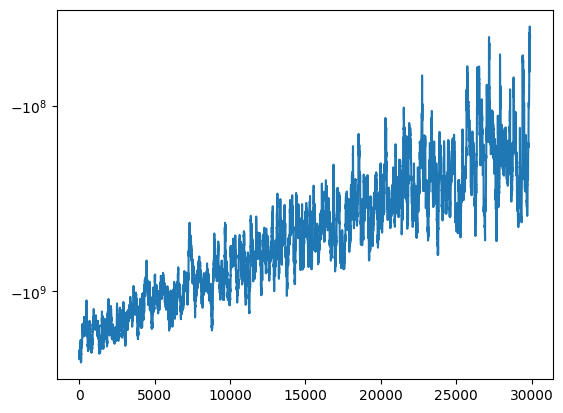

In [35]:
plt.plot(sliding_window_view(elbos, 100).mean(axis=1))
plt.yscale('symlog')

See "Variational Relevance Vector Machines" by Bishop, Tipping (2000, UAI), Eq.~35-38. Note that our $\tau^2$ is $\alpha^{-1}$ there. And their $\tau$ is our $\sigma_{\varepsilon}^2$.

The pred. posterior is approx. normal.
This also directly transfers to the horseshoe (bc in Bishop, Tipping $\alpha$ is a vector with a different shrinkage element for each $w_l$, $l = 1, \ldots L$.

In [26]:
X_test = torch.linspace(-10,10, 300).unsqueeze(1)
Psi_test = lli_net.get_ll_embedd(X_test)
pred_mean = (Psi_test @  last_layer_vi.mu.T).detach().numpy().squeeze()
Sigma_q  = last_layer_vi.get_Sigma_q().squeeze()
Z = torch.diag(Psi_test @ torch.diag(Sigma_q[:L]) @ Psi_test.T)
pred_std = torch.sqrt(Z + sigma_eps_sq).detach().numpy()

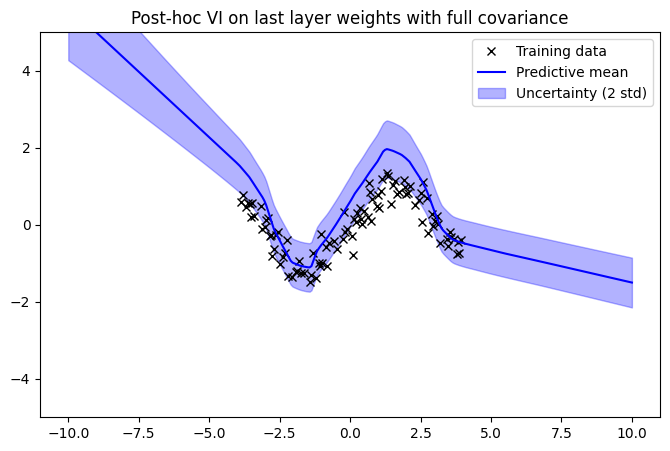

In [32]:
plt.figure(figsize=(8,5))
plt.ylim(-5,5)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance")
plt.show()


# Horseshoe
For the horseshoe prior we have a separate variance parameter $\tau_l^2$ for each weight $w_l$ resulting in for $l = 1, \ldots, L$. Each variance parameter follows an inverse-gamma distribution
\begin{align}
\tau_l^2  \sim \mathcal{HC}(0, 1)
\end{align}
Technically the horseshoe also has a global shrinkage component, but we just set this to 1. 

We only have to make some minor changes to the ELBO to integrate the horseshoe prior:

\begin{align}
\text{ELBO}(\lambda) = E_{q_\lambda}[\log p(y \mid x, w, \textcolor{red}{\tau_1^2, \ldots \tau_L^2}, \sigma_{\varepsilon}^2)] -\mathbb{E}_{q_\lambda}[KL(q_{\lambda}(w) || p(w |\textcolor{red}{\tau_1^2, \ldots, \tau_L^2}))] - KL( q_{\lambda}(\tau^2) || p(\tau^2 )) -  - KL( q_{\lambda}(\sigma_{\varepsilon}^2) || p(\sigma_{\varepsilon}^2))
\end{align}

We need to update the log-likelihood, and one two KL divergences.

In [13]:
class LastLayerVIHorseshoe(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_lambda_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_sigma_eps_sq_mu = nn.Parameter(torch.zeros(out_features, 1))

        total_dim = in_features + in_features + 1
        self.Sigma_q_unconstrained = nn.Parameter(
            torch.randn(out_features, total_dim) * 0.01
        )
    
    def get_sigma_eps_sq(self):
        return torch.exp(self.log_sigma_eps_sq_mu)

    def get_Sigma_q(self):
        return torch.nn.functional.softplus(self.Sigma_q_unconstrained) + 1e-5
    
    def forward(self, X, S=5):

        params = torch.cat([self.mu, self.log_lambda_mu, self.log_sigma_eps_sq_mu], dim=-1)
        
        eps = torch.randn(S, params.shape[1], device=params.device)
        Sigma_q = self.get_Sigma_q()
        params_samples = params + Sigma_q * eps

        w_samples = params_samples[:, :self.in_features]
        y_sample = X @ w_samples.T
        
        return params_samples, params, y_sample, Sigma_q
    
    def forward_sample(self, X, S=1):
        params = torch.cat([self.mu, self.log_lambda_mu, self.log_sigma_eps_sq_mu], dim=-1)
        eps = torch.randn(S, params.shape[1], device=params.device)
        Sigma_q = self.get_Sigma_q()
        params_samples = params + Sigma_q * eps
        
        w_samples = params_samples[:, :self.in_features]
        y_sample = X @ w_samples.T
        return y_sample


In [14]:
last_layer_vi_hs = LastLayerVIHorseshoe(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi_hs.parameters(), lr=1e-3)
num_epochs = 10000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [15]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    # Forward pass: sample params from variational distribution
    params_samples, params, y_sample, Sigma_q = last_layer_vi_hs.forward(Psi)

    # Extract samples of parameters
    w_samples = params_samples[:, :last_layer_vi_hs.in_features]  # shape [S, p]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5  # [S]
    # Local scale samples λ_j (log λ_j ~ Normal(m_j, s_j^2))
    lambda_samples = torch.exp(params_samples[:, last_layer_vi_hs.in_features:-1]) + 1e-8  # [S, p]

    # Variational means/vars
    q_w_mu = params[:, :last_layer_vi_hs.in_features]  # [S, p]
    q_lambda_mu = params[:, last_layer_vi_hs.in_features:-1]  # mean of log λ_j
    q_lambda_var = Sigma_q[:, last_layer_vi_hs.in_features:-1]  # var of log λ_j

    q_log_sigma_eps_sq_mu = params_samples[:, -1]
    q_log_sigma_eps_sq_var = Sigma_q[:, -1]

    # Likelihood term E_q[ log p(y | x, w, σ^2) ]
    log_likelihood = (
        -0.5 * N * torch.log(sigma_eps_sq_samples.unsqueeze(0))
        -0.5 * (ys_train - y_sample) ** 2 / sigma_eps_sq_samples.unsqueeze(0))
  # shape [S]
    ll_term = log_likelihood.sum(dim=0).mean()

    # KL term for w: E_q[ KL(q(w) || p(w | λ)) ]
    # Gaussian-Gaussian KL, averaged over λ samples
    # Σ_q_diag = variances of q_w
    Sigma_w_diag = Sigma_q[:, :last_layer_vi_hs.in_features]  # [S, p]
    # Expectations: λ^{-2} and log λ^2
    E_inv_lambda_sq = torch.exp(-2 * q_lambda_mu + 2 * q_lambda_var)  # analytic
    E_log_lambda_sq = 2 * q_lambda_mu
    kl_w = 0.5 * torch.sum(
        (Sigma_w_diag.mean(dim=0) + q_w_mu.mean(dim=0)**2) * E_inv_lambda_sq.mean(dim=0)
        - 1
        + E_log_lambda_sq.mean(dim=0)
        - torch.log(Sigma_w_diag.mean(dim=0) + 1e-8)
    )

    # KL term for λ_j: KL(q(λ_j) || p(λ_j)), p(λ_j) = half-Cauchy(0,1)
    # Monte Carlo estimate
    q_log_pdf_lambda = q_log_pdf_lognormal(lambda_samples, q_lambda_mu, q_lambda_var)
    log_p_lambda = math.log(2.0 / math.pi) - torch.log(1.0 + lambda_samples**2)
    kl_lambda = torch.sum((q_log_pdf_lambda - log_p_lambda).mean(dim=0))  # sum over j

    # KL term for σ^2: KL(q(σ_ε^2) || p(σ_ε^2))
    q_log_pdf_sigma_eps = q_log_pdf_lognormal(sigma_eps_sq_samples,
                                              q_log_sigma_eps_sq_mu,
                                              q_log_sigma_eps_sq_var)
    
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)

    # ELBO
    elbo = ll_term - kl_w - kl_lambda - kl_sigma_eps_sq_value
    loss = -elbo

    loss.backward()
    optimizer_vi.step()

    if epoch % 100== 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())


VI epoch 0 ELBO: -1131.981
VI epoch 100 ELBO: 2062.477
VI epoch 200 ELBO: 125.977
VI epoch 300 ELBO: 1142.559
VI epoch 400 ELBO: 3627.274
VI epoch 500 ELBO: 1542.515
VI epoch 600 ELBO: 2418.313
VI epoch 700 ELBO: 5920.010
VI epoch 800 ELBO: 3086.769
VI epoch 900 ELBO: 4026.881
VI epoch 1000 ELBO: 5440.363
VI epoch 1100 ELBO: 5746.101
VI epoch 1200 ELBO: 7228.801
VI epoch 1300 ELBO: 6148.156
VI epoch 1400 ELBO: 3967.465
VI epoch 1500 ELBO: 8385.855
VI epoch 1600 ELBO: 9346.343
VI epoch 1700 ELBO: 7822.567
VI epoch 1800 ELBO: 8424.598
VI epoch 1900 ELBO: 7831.935
VI epoch 2000 ELBO: 9196.459
VI epoch 2100 ELBO: 8929.589
VI epoch 2200 ELBO: 13893.762
VI epoch 2300 ELBO: 11826.944
VI epoch 2400 ELBO: 13545.512
VI epoch 2500 ELBO: 11919.447
VI epoch 2600 ELBO: 13553.305
VI epoch 2700 ELBO: 13010.286
VI epoch 2800 ELBO: 14898.553
VI epoch 2900 ELBO: 15822.443
VI epoch 3000 ELBO: 13543.665
VI epoch 3100 ELBO: 16087.589
VI epoch 3200 ELBO: 16752.789
VI epoch 3300 ELBO: 15259.505
VI epoch 3400 

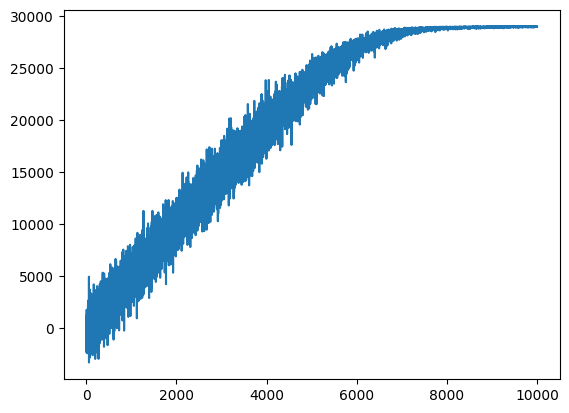

In [16]:
plt.plot(elbos)

In [17]:
X_test = torch.linspace(-10,10, 300).unsqueeze(1)
Psi_test = lli_net.get_ll_embedd(X_test)
pred_mean = (Psi_test @  last_layer_vi_hs.mu.T).detach().numpy().squeeze()
Sigma_q  = last_layer_vi_hs.get_Sigma_q().squeeze()
Z = torch.diag(Psi_test @ torch.diag(Sigma_q[:L]) @ Psi_test.T)
pred_std = torch.sqrt(Z + sigma_eps_sq).detach().numpy()

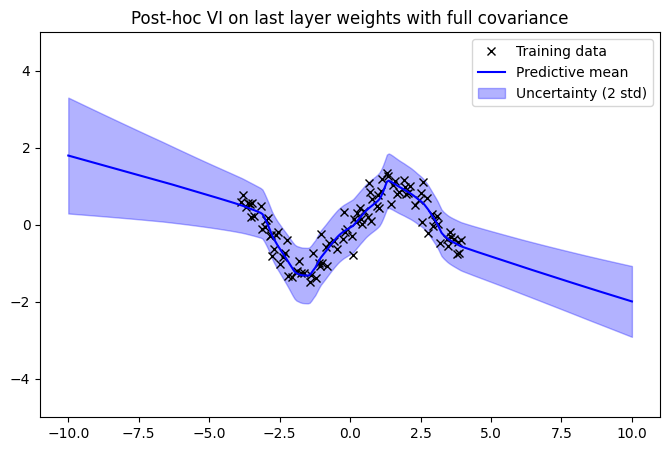

In [18]:
plt.figure(figsize=(8,5))
plt.ylim(-5,5)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance")
plt.show()

# Ridge + FullCov

We now want to improved our predictive uncertainty by allowing for a full, factored covariance matrix:
\begin{align}
\Sigma = BB^T + D
\end{align}
where $D$ is a diagonal matrix and $B$ is a full rank, lower triangular $L \times F$ matrix with $F << L $. This covariance matrix is much more flexible than a diagonal covariance matrix. And, if the rank of the triangular factor $F$ is chosen small (e.g. < 10) also computationally lightweight.


In [4]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)


class LastLayerVIRidgeFullCov(nn.Module):
    def __init__(self, in_features, out_features, rank_B = 5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.q_dim = in_features + 2
        self.rank_B = rank_B
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_tau_sq = nn.Parameter(torch.ones(out_features, 1))
        self.log_sigma_eps_sq = nn.Parameter(torch.ones(out_features, 1))

        self.cov_factor=nn.Parameter(torch.ones(self.q_dim, self.rank_B)*0.001)
        self.cov_diag=nn.Parameter(torch.ones(1, self.q_dim)*0.01)

    def get_B(self, B_unconstrained):
            mask = torch.tril(torch.ones(self.q_dim, self.rank_B))
            B = B_unconstrained * mask
            return B
    
    def get_tau_sq(self):
        return torch.nn.functional.exp(self.log_tau_sq)
    
    def get_sigma_eps_sq(self):
        return torch.nn.functional.exp(self.log_sigma_eps_sq)

    def get_Sigma_q(self):
        B = self.get_B(self.cov_factor)
        D = torch.diag((torch.nn.functional.softplus(self.cov_diag) + 1e-5))
        Sigma_q = B @ B.T + D

        return Sigma_q, B, D
    
    def forward(self, X, S = 5):
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        Sigma_q, B, D = self.get_Sigma_q()
        D_sqrt = D.squeeze()

        t = torch.randn(S, self.rank_B)
        eps = torch.randn(S, self.q_dim)

        params_samples = params + t @ B.T + D_sqrt*eps 

        y_sample = (params_samples[:, :self.in_features] @ X.T)
        
        return params_samples, params, y_sample, Sigma_q

In [5]:
last_layer_vi = LastLayerVIRidgeFullCov(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-3)
num_epochs = 20000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [6]:
def kl_w_vectorized_full_cov(mu_samples, Sigma_q, tau_sq_samples):
    """
    mu_samples: shape [S, L] (sampled w's)
    Sigma_q: shape [L, L] (covariance of q(w))
    tau_sq_samples: shape [S] (sampled tau^2)
    """
    L = Sigma_q.shape[0]
    
    # log determinant of Sigma_q
    logdet_Sigma = torch.logdet(Sigma_q + 1e-5 * torch.eye(L))
    
    # trace of Sigma_q / tau_sq_samples
    trace_term = torch.trace(Sigma_q) / tau_sq_samples
    mu_norm_sq = torch.sum(mu_samples**2, dim=1) / tau_sq_samples
    log_tau_sq = torch.log(tau_sq_samples)
    
    kl = 0.5 * (trace_term + mu_norm_sq - L + L * log_tau_sq - logdet_Sigma)
    
    return kl.mean()


def q_log_pdf_lognormal(x_samples, mu_log, log_var_log):
    var_log = torch.exp(log_var_log)
    log_x = torch.log(x_samples)
    log_pdf = -log_x - 0.5 * torch.log(2 * torch.pi * var_log) - (log_x - mu_log)**2 / (2 * var_log)
    return log_pdf  # shape [S]

def log_p_sigma_eps_sq_ig(x, a_sigma, b_sigma):
    log_prob = a_sigma * math.log(b_sigma) - torch.lgamma(torch.tensor(a_sigma)) \
               - (a_sigma + 1) * torch.log(x) - b_sigma / x
    return log_prob

def kl_sigma_eps_sq(q_log_pdf, sigma_eps_sq_samples, a_sigma, b_sigma):
    log_prior = log_p_sigma_eps_sq_ig(sigma_eps_sq_samples, a_sigma, b_sigma)
    return (q_log_pdf - log_prior).mean()

def kl_tau_sq(q_log_pdf, tau_sq_samples, a_tau, b_tau):
    log_prior = a_tau * torch.log(torch.tensor(b_tau)) - torch.lgamma(torch.tensor(a_tau)) \
                - (a_tau + 1) * torch.log(tau_sq_samples) - b_tau / tau_sq_samples
    return (q_log_pdf - log_prior).mean()

In [7]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    # forward pass
    params_samples, params, y_sample, Sigma_q = last_layer_vi.forward(Psi)

    # sample parameters
    w_samples = params_samples[:, :last_layer_vi.in_features]
    tau_sq_samples = torch.nn.functional.softplus(params_samples[:, -2]) + 1e-5
    sigma_eps_sq_samples = (torch.nn.functional.softplus(params_samples[:, -1]) + 1e-5) #.unsqueeze(0)

    # variational means
    q_w_mu = params[:, :last_layer_vi.in_features]
    q_log_tau_sq_mu = params[:, -2]
    q_log_sigma_eps_sq_mu = params[:, -1]

    # variances from Sigma_q
    q_log_tau_sq_var = Sigma_q[-2, -2]
    q_log_sigma_eps_sq_var = Sigma_q[-1, -1]

    # likelihood
    log_likelihood = -0.5 * N * torch.log(sigma_eps_sq_samples) \
                     -0.5 * torch.sum((ys_train.squeeze().unsqueeze(0) - y_sample)**2, dim = 1) / sigma_eps_sq_samples
    log_likelihood = log_likelihood.mean()

    # KL terms
    kl_w = kl_w_vectorized_full_cov(w_samples, Sigma_q[:last_layer_vi.in_features, :last_layer_vi.in_features], tau_sq_samples)
    
    q_log_pdf_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    kl_sigma_eps = kl_sigma_eps_sq(q_log_pdf_eps, sigma_eps_sq_samples, a_sigma=2, b_sigma=2)
    
    q_log_pdf_tau = q_log_pdf_lognormal(tau_sq_samples, q_log_tau_sq_mu, q_log_tau_sq_var)
    kl_tau = kl_tau_sq(q_log_pdf_tau, tau_sq_samples, a_tau=2, b_tau=2)

    # ELBO
    elbo = log_likelihood - kl_sigma_eps - kl_tau - kl_w
    loss = -elbo

    # backward
    loss.backward()
    optimizer_vi.step()

    if epoch % 1000 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())


VI epoch 0 ELBO: -406.131
VI epoch 1000 ELBO: -300.869
VI epoch 2000 ELBO: -235.816
VI epoch 3000 ELBO: -186.510
VI epoch 4000 ELBO: -154.068


KeyboardInterrupt: 

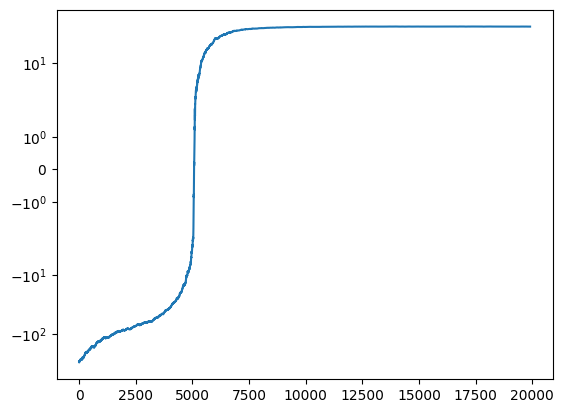

In [51]:
plt.plot(sliding_window_view(elbos, 100).mean(axis=1))
plt.yscale('symlog')

In [52]:
X_test = torch.linspace(-10, 10, 300).unsqueeze(1)
with torch.no_grad():
    Psi_test = lli_net.get_ll_embedd(X_test)

pred_mean = (Psi_test @ last_layer_vi.mu.T).detach().numpy().squeeze()
Sigma_q, B, D = last_layer_vi.get_Sigma_q()

L = last_layer_vi.in_features
Sigma_w = Sigma_q[:L, :L]
Z = torch.diag(Psi_test @ Sigma_w @ Psi_test.T) + 1e-6

sigma_eps_sq = torch.exp(last_layer_vi.log_sigma_eps_sq).squeeze() 
pred_std = torch.sqrt(Z + sigma_eps_sq).detach().numpy()


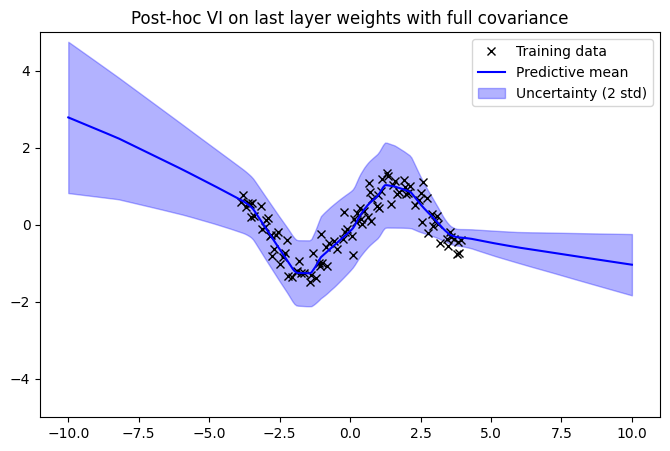

In [54]:
plt.figure(figsize=(8,5))
plt.ylim(-5,5)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance")
plt.show()

# Horseshoe + FullCov

In [23]:
class LastLayerVIHorseshoeFullCov(nn.Module):
    def __init__(self, in_features, out_features, rank_B):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.q_dim = in_features*2 + 1
        self.rank_B = rank_B
        
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_lambda_mu = nn.Parameter(torch.ones(out_features, in_features)*0.01)
        self.log_sigma_eps_sq_mu = nn.Parameter(torch.zeros(out_features, 1))

        self.cov_factor=nn.Parameter(torch.ones(self.q_dim, self.rank_B)*0.01)
        self.cov_diag=nn.Parameter(torch.zeros(1, self.q_dim))

    def get_B(self, B_unconstrained):
            mask = torch.tril(torch.ones(self.q_dim, self.rank_B))
            B = B_unconstrained * mask
            return B
    

    def get_Sigma_q(self):
        B = self.get_B(self.cov_factor)
        D = (torch.exp(self.cov_diag) + 1e-5).squeeze()
        Sigma_q = B @ B.T + D

        return Sigma_q, B, D
    
    def forward(self, X, S = 5):
        params = torch.cat([self.mu, self.log_lambda_mu, self.log_sigma_eps_sq_mu], dim = -1 )
        Sigma_q, B, D = self.get_Sigma_q()
        D_sqrt = torch.sqrt(D).squeeze()

        t = torch.randn(S, self.rank_B)
        eps = torch.randn(S, self.q_dim)

        params_samples = params + t @ B.T + D_sqrt*eps 

        y_sample = (params_samples[:, :self.in_features] @ X.T)
        
        return params_samples, params, y_sample, Sigma_q, B, D


In [24]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

last_layer_vi_hs_full_cov = LastLayerVIHorseshoeFullCov(in_features=Psi.shape[1], out_features=1, rank_B = 5)
optimizer_vi = Adam(last_layer_vi_hs_full_cov.parameters(), lr=1e-3)
num_epochs = 15000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [25]:
def kl_full_cov_w_hs(mu_w, Sigma_w, lambda_vec, L):

    inv_Lambda = torch.diag(1.0 / (lambda_vec**2))
    term_trace = torch.trace(inv_Lambda @ Sigma_w)
    diff_inv = mu_w.unsqueeze(0).squeeze()  @ inv_Lambda                  
    term_quad = torch.sum(diff_inv * mu_w.unsqueeze(0).squeeze() , dim=1) 
    term_logdet = torch.logdet(torch.diag(lambda_vec**2)) - torch.logdet(Sigma_w + 1e-5*torch.eye(L))
    kl = 0.5 * (term_trace + term_quad - L + term_logdet)
    return kl.mean()

In [26]:
Psi.shape

torch.Size([100, 50])

In [27]:
def q_log_pdf_lognormal(sigma_eps_sq_samples, mu_log, log_var_log):

    var_log = torch.exp(log_var_log)
    log_x = torch.log(sigma_eps_sq_samples)
    log_pdf = (
        - log_x
        - 0.5 * torch.log(2 * torch.pi * var_log)
        - (log_x - mu_log)**2 / (2 * var_log)
    )
    return log_pdf

def kl_sigma_eps_sq(q_log_pdf, sigma_eps_sq_samples, a_sigma, b_sigma):
    log_prior = log_p_sigma_eps_sq_ig(sigma_eps_sq_samples, a_sigma, b_sigma)
    return (q_log_pdf - log_prior).mean()

def log_p_sigma_eps_sq_ig(x, a_sigma, b_sigma):
    log_prob = a_sigma * math.log(b_sigma) - torch.lgamma(torch.tensor(a_sigma)) \
               - (a_sigma + 1) * torch.log(x) - b_sigma / x
    return log_prob


In [28]:
def kl_lambda_hs(q_log_pdf_loglambda, lambda_samples):
    """
    Computes KL[q(log λ) || p(λ)] with a Half-Cauchy(0,1) prior.
    
    q_log_pdf_loglambda : [S] or [S,p] log probability of log(lambda) under the variational Normal
    lambda_samples      : [S,p] samples in original scale (positive)
    """
    # Half-Cauchy(0,1) prior log-density in original scale
    log_prior_hc = torch.sum(torch.log(2.0 / (torch.pi * (1.0 + lambda_samples**2))), dim=-1)
    
    # Log-Jacobian of the transformation log λ -> λ
    log_jacobian = torch.sum(torch.log(lambda_samples), dim=-1)
    
    # KL = E_q[ log q(log λ) - log p(λ) - log|dλ/dlogλ| ]
    kl = q_log_pdf_loglambda - log_prior_hc - log_jacobian
    return kl.mean()


In [29]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    params_samples, params, y_sample, Sigma_q, B, D = last_layer_vi_hs_full_cov.forward(Psi)

    # Samples
    w_samples = params_samples[:, :last_layer_vi_hs_full_cov.in_features]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5
    lambda_samples = torch.exp(params_samples[:, last_layer_vi_hs_full_cov.in_features:-1]) + 1e-5

    # Variational means/vars
    q_lambda_mu = params[:, last_layer_vi_hs_full_cov.in_features:-1]
    q_log_sigma_eps_sq_mu = params[:, -1]
    q_log_sigma_eps_sq_var = Sigma_q[-1, -1]
    Sigma_w = Sigma_q[:last_layer_vi_hs_full_cov.in_features, :last_layer_vi_hs_full_cov.in_features]

    # Likelihood
    log_likelihood = (
        -0.5 * N * torch.log(sigma_eps_sq_samples.unsqueeze(0))
        -0.5 * torch.sum((ys_train.squeeze().unsqueeze(0) - y_sample) ** 2, dim = 1) / sigma_eps_sq_samples.unsqueeze(0))
    ll_term = log_likelihood.sum(dim=0).mean()

    # KLs
    # some variables we need
    lambda_start = last_layer_vi_hs_full_cov.in_features
    lambda_end = 2*lambda_start
    B_lambda = B[lambda_start:lambda_end,:]
    D_lambda = D[lambda_start:lambda_end].unsqueeze(0)
    q_lambda_dist = LowRankMultivariateNormal(
        loc=q_lambda_mu, 
        cov_factor=B_lambda, 
        cov_diag=D_lambda
    )
    q_log_pdf_lambda = q_lambda_dist.log_prob(torch.log(lambda_samples))
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    # actuak KLs
    kl_w = kl_full_cov_w_hs(w_samples, Sigma_w, torch.exp(q_lambda_mu.squeeze() + 1e-5), L)
    kl_lambda = kl_lambda_hs(q_log_pdf_lambda, lambda_samples)
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)

    # ELBO
    elbo = ll_term   - kl_sigma_eps_sq_value - kl_lambda -  kl_w
    loss = -elbo

    loss.backward()
    optimizer_vi.step()

    if epoch % 100== 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())


VI epoch 0 ELBO: -733.290
VI epoch 100 ELBO: -467.811
VI epoch 200 ELBO: -415.876
VI epoch 300 ELBO: -686.308
VI epoch 400 ELBO: -385.322


KeyboardInterrupt: 

In [30]:
from models.vi import run_last_layer_vi_horseshoe_full_fac

In [33]:
last_layer_vi = LastLayerVIHorseshoeFullCov(in_features=Psi.shape[1], out_features=1, rank_B = 30)
optimizer_vi = torch.optim.Adam(last_layer_vi.parameters(), lr=1e-3)
run_last_layer_vi_horseshoe_full_fac(last_layer_vi_hs_full_cov, Psi, ys_train, optimizer_vi, 1000)

VI epoch 0 ELBO: -425.363
VI epoch 100 ELBO: -460.831
VI epoch 200 ELBO: -580.345
VI epoch 300 ELBO: -765.818
VI epoch 400 ELBO: -377.787


KeyboardInterrupt: 

In [310]:
print(ll_term, kl_sigma_eps_sq_value, kl_lambda,kl_w)

tensor(69.5901, grad_fn=<MeanBackward0>) tensor(9.8237, grad_fn=<MeanBackward0>) tensor(4.0376, grad_fn=<MeanBackward0>) tensor(20.3569, grad_fn=<MeanBackward0>)


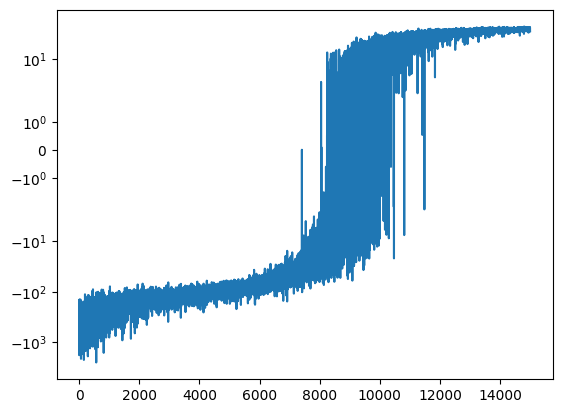

In [311]:
plt.plot(elbos) #sliding_window_view(elbos, 100).mean(axis=1
plt.yscale('symlog')

In [312]:
X_test = torch.linspace(-10, 10, 300).unsqueeze(1)
with torch.no_grad():
    Psi_test = lli_net.get_ll_embedd(X_test)

pred_mean = (Psi_test @ last_layer_vi_hs_full_cov.mu.T).detach().numpy().squeeze()
Sigma_q, B, D = last_layer_vi_hs_full_cov.get_Sigma_q()

L = last_layer_vi_hs_full_cov.in_features
Sigma_w = Sigma_q[:L, :L]
Z = torch.sum((Psi_test @ Sigma_w) * Psi_test, dim=1) #torch.diag(Psi_test @ Sigma_w @ Psi_test.T) #

sigma_eps_sq = torch.exp(last_layer_vi_hs_full_cov.log_sigma_eps_sq_mu).squeeze() 
pred_std = torch.sqrt( Z + sigma_eps_sq).detach().numpy()

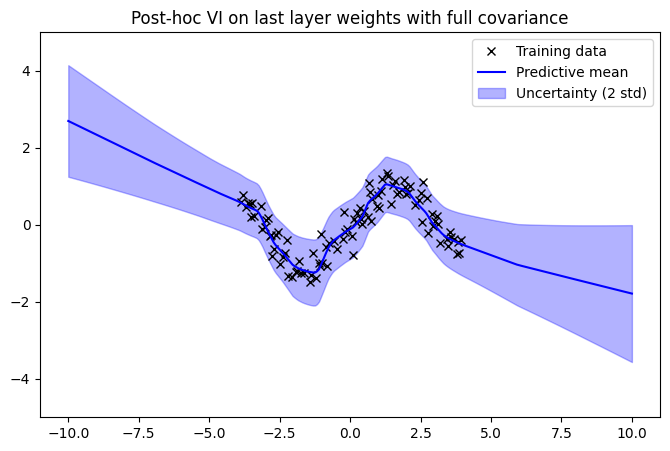

In [313]:
plt.figure(figsize=(8,5))
plt.ylim(-5,5)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance")
plt.show()